In [272]:
import pandas as pd
import os
from magpy.oracles.mixed import MixedDataOracle
from magpy.search.pcskeleton import pc_skeleton, parallel_pc_skeleton
import logging
import networkx as nx
import matplotlib.pyplot as plt

try:
    _SETUP
except NameError:
    os.chdir("..")
    _SETUP = True


logging.basicConfig(level=logging.INFO)

print("running on folder: ", os.getcwd())

df = pd.read_csv("data/SF_Traffic.csv")

running on folder:  /Users/andre/magpy


/var/folders/5d/bg50v_hd3b90vwxc83124gt00000gn/T/ipykernel_29242/1622598177.py:20: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/SF_Traffic.csv")


In [273]:
df = df[
    [
        "accident_year",
        "dph_col_grp_description",
        "party2_move_pre_acc",
        "collision_severity",
        "type_of_collision",
        "weather_1",
        "number_killed",
        "party1_move_pre_acc",
        "road_cond_1",
        "lighting",
        "number_injured",
        "analysis_neighborhood",
        "day_of_week",
    ]
]

# let's encode this as a string so it gets treated as a categorical variable since we don't expect a
df["accident_year"] = df["accident_year"].astype(str)
df["day_of_week"] = df["day_of_week"].astype(str)

In [96]:
df.dropna().to_csv("data/sf_traffic_clean.csv", index=False)

## Running causal discovery

Let's first define a conditional independence test - this is an object that, as the name suggests, test whether two variables are conditionally independent given a set of conditioning variables.

In this problem we will use the `MixedDataOracle` which implements a conditional independence test based on a Linear Discriminant Analysis (LDA) classifier, as well as a Chi Square contingency test.

The `threshold` parameter controls the significance level of the conditional independence test.


In [4]:
oracle = MixedDataOracle(df.dropna(), threshold=0.01)

In [5]:
# Low p-value -> high association! These are not independent!
oracle._run("number_killed", "number_injured", [])

1.1102230246251565e-16

In [6]:
# P-value is high -> these are likely independent!
oracle._run("number_killed", "number_injured", ["collision_severity"])

0.18890806975492502

`Number killed` and `number injured` are likely independent, since when we control for the `collision severity` the p-value is high.

The causal story is that `collision severity` determines the number of people killed and injured.

You can just get a yes/no answer by asking the oracle directly:


In [7]:
oracle("number_killed", "number_injured", ["collision_severity"])

True

## Running a skeleton search

Now let's try the following: for every pair of variables, we check if they are independent given their neighbors. But instead of randomly checking every possible combination of variables to test, we take a gradual approach, in which we first check pairs without a conditioning set, remove edges, then incrementally increase the size of the conditioning set.

To run the entire search, you can just call:

```python
skeleton, sepsets = parallel_pc_skeleton(
    oracle, df.columns, n_jobs=20, verbose=True
)
```

This will run the entire search in one go. And should take a while to complete (15 mins or so).

Let's do the search in smaller chunks instead:


In [8]:
# We use the max_set_size parameter to control the size of the conditioning set.

skeleton, sepsets = parallel_pc_skeleton(
    oracle, df.columns, max_sepset_size=1, n_jobs=20, verbose=True
)

INFO:root:Processing conditioning set of size: 0
INFO:root:Cond set 0: Processing 78 edges
Processing: 100%|██████████| 78/78 [00:17<00:00,  4.56it/s]


 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM parameter number 10 had an illegal value
 ** On entry to DGESDDM p

INFO:root:Removed edge accident_year -- day_of_week based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge collision_severity -- road_cond_1 based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge collision_severity -- day_of_week based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge weather_1 -- number_killed based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge weather_1 -- day_of_week based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge number_killed -- road_cond_1 based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge number_killed -- analysis_neighborhood based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge number_killed -- day_of_week based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge road_cond_1 -- number_injured based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge road_cond_1 -- da

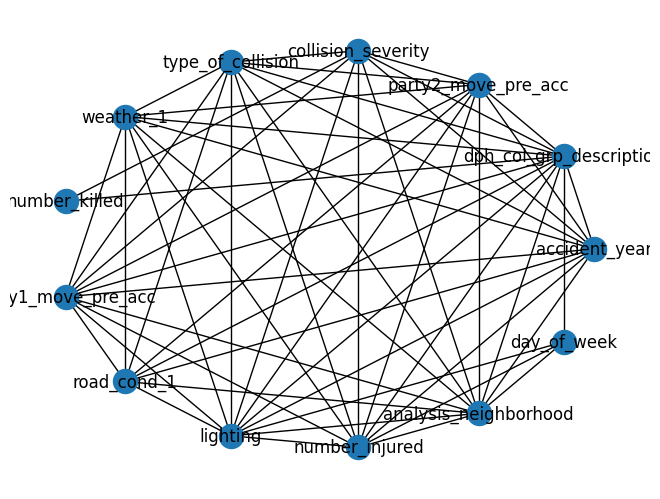

In [9]:
G = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(G, with_labels=True)
plt.show()

Now we just discovered a candidate skeleton! But that's not everything, with the skeleton object we can now check for conditional independencies of size 2 and 3.

We can use the `mat` parameter to pass the skeleton we just discovered, and the `set_sizes` parameter to check for conditional independencies of a particular size.

Before we do that, also let's take a look at the sepset object. Sepset refers to the separation set - it tells us which variables were used to "separate" two variables: i.e., ice cream sales and shark attacks are likely dependent, but if we control for the temperature, they become independent - (temperature) is the separation set.


In [10]:
sepsets[
    "number_killed", "day_of_week"
]  # likely to be the empty set - i.e., there's no association at all

[]

In [11]:
sepsets[
    "accident_year", "number_killed"
]  # likely to be the collision severity - i.e., if we control for the collision severity, then accident year and number killed are independent. probably the structure is accident_year -> collision_severity -> number_killed

['collision_severity']

In [12]:
skeleton, sepsets = parallel_pc_skeleton(
    oracle, df.columns, mat=skeleton, set_sizes=[2, 3], n_jobs=20, verbose=True
)

INFO:root:Processing conditioning set of size: 0
INFO:root:Processing conditioning set of size: 1
INFO:root:Processing conditioning set of size: 2
INFO:root:Cond set 2: Processing 58 edges
Processing: 100%|██████████| 2607/2607 [03:55<00:00, 11.06it/s]
INFO:root:Removed edge accident_year -- lighting based on the conditioning set: ('weather_1', 'party2_move_pre_acc') (cond_set_size: 2)
INFO:root:Removed edge accident_year -- lighting based on the conditioning set: ('type_of_collision', 'party1_move_pre_acc') (cond_set_size: 2)
INFO:root:Removed edge accident_year -- lighting based on the conditioning set: ('dph_col_grp_description', 'analysis_neighborhood') (cond_set_size: 2)
INFO:root:Removed edge accident_year -- lighting based on the conditioning set: ('party2_move_pre_acc', 'analysis_neighborhood') (cond_set_size: 2)
INFO:root:Removed edge accident_year -- lighting based on the conditioning set: ('analysis_neighborhood', 'collision_severity') (cond_set_size: 2)
INFO:root:Removed ed

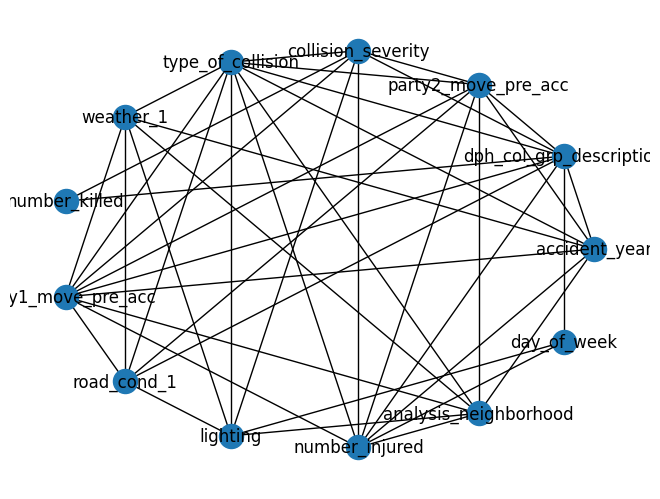

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(G, with_labels=True)
plt.show()

In [14]:
skeleton.loc[:, "number_killed"].sort_values(ascending=False)

dph_col_grp_description    1.0
collision_severity         1.0
accident_year              0.0
party2_move_pre_acc        0.0
type_of_collision          0.0
weather_1                  0.0
number_killed              0.0
party1_move_pre_acc        0.0
road_cond_1                0.0
lighting                   0.0
number_injured             0.0
analysis_neighborhood      0.0
day_of_week                0.0
Name: number_killed, dtype: float64

In [15]:
skeleton.loc[:, "number_injured"].sort_values(ascending=False)

accident_year              1.0
dph_col_grp_description    1.0
party2_move_pre_acc        1.0
collision_severity         1.0
type_of_collision          1.0
party1_move_pre_acc        1.0
day_of_week                1.0
analysis_neighborhood      1.0
weather_1                  0.0
road_cond_1                0.0
number_killed              0.0
number_injured             0.0
lighting                   0.0
Name: number_injured, dtype: float64

In [16]:
skeleton.loc[:, "collision_severity"].sort_values(ascending=False)

dph_col_grp_description    1.0
type_of_collision          1.0
party2_move_pre_acc        1.0
party1_move_pre_acc        1.0
number_killed              1.0
number_injured             1.0
lighting                   1.0
collision_severity         0.0
accident_year              0.0
road_cond_1                0.0
weather_1                  0.0
analysis_neighborhood      0.0
day_of_week                0.0
Name: collision_severity, dtype: float64

## Estimating the impact of lighting conditions on collision severity


In [25]:
# let's first look oat ur treatment variable.

df["lighting"].value_counts()

lighting
Daylight                                38719
Dark - Street Lights                    17981
Dusk - Dawn                              2090
Not Stated                                597
Dark - No Street Lights                   437
Dark - Street Lights Not Functioning      107
Name: count, dtype: int64

In [343]:
# let's try to work on the following hypothesis: what would happen if we make the lighting conditions better?

night_accidents = df[
    df["lighting"].isin(
        [
            "Dark - No Street Lights",
            "Dark - Street Lights Not Functioning",
            "Dark - Street Lights",
        ]
    )
].copy()

In [344]:
p = (
    night_accidents.groupby(["lighting", "collision_severity"])["number_killed"]
    .count()
    .unstack(level=1)
)
p["s"] = p.sum(axis=1)
p.loc["s", :] = p.sum(axis=0)

p.div(p["s"], axis=0) * 100

collision_severity,Fatal,Injury (Complaint of Pain),Injury (Other Visible),Injury (Severe),s
lighting,,,,,
Dark - No Street Lights,2.745995,57.208238,28.832952,11.212815,100.0
Dark - Street Lights,1.351502,61.484983,27.947720,9.215795,100.0
Dark - Street Lights Not Functioning,2.803738,57.009346,29.906542,10.280374,100.0
s,1.392788,61.358238,27.979918,9.269056,100.0


In [345]:
# So let's think about it. It looks like adding street lights reduces the proportion of fatal accidents:


# P( Fatal | Dark - No Street Lights ) = 2.75%
# P( Fatal | Dark - Street Lights ) = 1.35%
# P( Fatal | Dark - Street Lights Not Functioning ) = 2.8%

# WAnd we have a similar relationship for severe injuries. So what's the initial conclusion here?
# If we somehow go from "No Street Lights" to "Dark - Street Lights" it looks like we have a chance of saving lives, but how many are we talking here?

In [346]:
night_accidents[
    night_accidents["collision_severity"].isin(["Fatal", "Injury (Severe)"])
    & night_accidents["lighting"].isin(
        [
            "Dark - Street Lights",
        ]
    )
][["number_injured", "dph_col_grp_description"]].groupby(
    "dph_col_grp_description"
).sum()

,number_injured
dph_col_grp_description,
Bicycle Only,67
Bicycle-Parked Car,14
Bicycle-Pedestrian,21
Pedestrian Only or Pedestrian-Parked Car,1
Unknown/Not Stated,2
Vehicle(s) Only Involved,1126
Vehicle-Bicycle,184
Vehicle-Pedestrian,844


In [347]:
# all of these individuals are prone to be treated: i.e.,
# these are accidents that happened at night with low visibility conditions.
# so the goal is to estimate the effect of adding street lights to these locations.

night_accidents[
    night_accidents["collision_severity"].isin(["Fatal", "Injury (Severe)"])
    & night_accidents["lighting"].isin(
        [
            "Dark - Street Lights Not Functioning",
            "Dark - No Street Lights",
        ]
    )
][["number_injured", "dph_col_grp_description"]].groupby(
    "dph_col_grp_description"
).sum()

,number_injured
dph_col_grp_description,
Bicycle Only,3
Vehicle(s) Only Involved,56
Vehicle-Bicycle,7
Vehicle-Pedestrian,30


In [348]:
night_accidents[
    night_accidents["collision_severity"].isin(["Fatal", "Injury (Severe)"])
][["number_injured", "dph_col_grp_description"]].groupby(
    "dph_col_grp_description"
).sum()

,number_injured
dph_col_grp_description,
Bicycle Only,70
Bicycle-Parked Car,14
Bicycle-Pedestrian,21
Pedestrian Only or Pedestrian-Parked Car,1
Unknown/Not Stated,2
Vehicle(s) Only Involved,1182
Vehicle-Bicycle,191
Vehicle-Pedestrian,874


In [349]:
# let's look at the skeleton and figure out which covariates we want to use, ideally these will be variables that are either:
# 1. confounding the treatment assignment and the outcome, i.e.: they cause both, or
# 2. causing the outcome, especially if there is some modifying effect (i.e, road conditions for instance)

skeleton.loc[:, "lighting"]

accident_year              0.0
dph_col_grp_description    0.0
party2_move_pre_acc        0.0
collision_severity         1.0
type_of_collision          1.0
weather_1                  1.0
number_killed              0.0
party1_move_pre_acc        0.0
road_cond_1                1.0
lighting                   0.0
number_injured             0.0
analysis_neighborhood      1.0
day_of_week                1.0
Name: lighting, dtype: float64

In [500]:
skeleton.loc[:, "collision_severity"]

accident_year              0.0
dph_col_grp_description    1.0
party2_move_pre_acc        1.0
collision_severity         0.0
type_of_collision          1.0
weather_1                  0.0
number_killed              1.0
party1_move_pre_acc        1.0
road_cond_1                0.0
lighting                   1.0
number_injured             1.0
analysis_neighborhood      0.0
day_of_week                0.0
Name: collision_severity, dtype: float64

In [568]:
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

covariates = [
    "weather_1",
    "day_of_week",
    # "dph_col_grp_description",
    # "party1_move_pre_acc",
    # "party2_move_pre_acc",
    # "type_of_collision",
    # "road_cond_1",
]

effect_estimation = EffectEstimator(
    night_accidents,
    classifier=RandomForestClassifier,
    classifier_kwargs={"max_depth": 4},
    regressor=RandomForestRegressor,
    regressor_kwargs={"max_depth": 4},
)
results = effect_estimation.estimate_ate(
    treatment=CategoricalTreatmentParams(
        column="lighting",
        treatment_classes=["Dark - Street Lights"],
    ),
    outcome=CategoricalOutcomeParams(
        column="collision_severity",
        treatment_classes=["Fatal", "Injury (Severe)"],
    ),
    covariates=covariates,
    max_classes=5,
)

print(results.explain())

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group True
INFO:causalml:     AUC   (Control):     0.5728
INFO:causalml:     AUC (Treatment):     0.5052
INFO:causalml:Log Loss   (Control):     0.3968
INFO:causalml:Log Loss (Treatment):     0.3373


The average treatment effect is: -0.0342, with a confidence interval of [-0.0634, -0.0050]. The baseline incidence is 0.1066, so the treatment has an uplift of -32.0740% of the outcome class.


In [581]:
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

covariates = [
    "weather_1",
    "day_of_week",
    # "dph_col_grp_description",
    "party1_move_pre_acc",
    "party2_move_pre_acc",
    # "type_of_collision",
    # "road_cond_1",
]

results = effect_estimation.fit_predict(
    treatment=CategoricalTreatmentParams(
        column="lighting",
        treatment_classes=["Dark - Street Lights"],
    ),
    outcome=CategoricalOutcomeParams(
        column="collision_severity",
        treatment_classes=["Fatal", "Injury (Severe)"],
    ),
    covariates=covariates,
)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group True
INFO:causalml:     AUC   (Control):     0.7378
INFO:causalml:     AUC (Treatment):     0.6199
INFO:causalml:Log Loss   (Control):     0.3715
INFO:causalml:Log Loss (Treatment):     0.3300


In [589]:
results.covariate_groups[2].sort_values("significance", ascending=False)

,mean_effect,std_effect,baseline_incidence_ratio,baseline_incidence_number,baseline_untreated_ratio,baseline_untreated_number,significance
party1_move_pre_acc,,,,,,,
Ran Off Road,-0.129231,0.060495,0.200000,39,0.071795,14,94.774710
Stopped In Road,-0.094688,0.060992,0.080420,23,0.034965,10,84.503163
Stopped,-0.115304,0.062048,0.049020,5,0.039216,4,83.990170
Backing,-0.101242,0.066142,0.034783,8,0.056522,13,83.029538
Making U Turn,-0.088632,0.060678,0.098305,29,0.033898,10,82.189011
Entering Traffic,-0.091157,0.064595,0.119617,50,0.038278,16,82.141524
Passing Other Vehicle,-0.099607,0.057502,0.100000,12,0.033333,4,81.834418
Not Stated,-0.089202,0.063739,0.310345,117,0.039788,15,81.656657
Slowing/Stopping,-0.107547,0.066650,0.038710,6,0.019355,3,75.204367
